In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from datetime import datetime, timezone, timedelta

In [6]:
data = pd.read_csv("data/prepared_dialogs/594508393.csv")



ua


In [ ]:
# USER_ID = ?


def calculate_dialog_sentiment(dataframe, result_path):
    """
    Calculate sentiment for each message in a dialog,
    and add it in a new column for a particular message,
    save result as a .csv file in {resultpath}
    
    Supported languages: eng, ru, ua
    """
    pass

    
def visualize_user_sentiment(sentiment_data):
    """
    Visualize sentiment data for a specific user
    in a timeline (linear graph), starting at 00:00 on Monday,
    finishing at 23:59 on Sunday
    """
    pass
    


def detect_data_language(data):
    key_letters = {
        "ua": {
            "є": 0, "і": 0, "ї": 0, "б": 0, "д": 0, "г": 0, "п": 0, "ц": 0, "я": 0, "ю": 0,
            "total": 0
        },
        "ru": {
            "ё": 0, "б": 0, "д": 0, "г": 0, "п": 0, "ц": 0, "я": 0, "ю": 0, "ы": 0, "э": 0,
            "total": 0
        },
        "en": {
            "d": 0, "f": 0, "g": 0, "j": 0, "q": 0, "r": 0, "s": 0, "v": 0, "w": 0, "z": 0,
            "total": 0
        }
    }
    dialog_step_msgs = []
    if data.index[-1] < 149:
        msgs_step = 1

    else:
        # in such way with msgs_step I can get 150 messages
        # which are at the different parts of the dialog, so
        # when I analyse there 150 msgs I can get a real language
        msgs_step = data.index[-1] // 150

    for i in range(0, data.index[-1], msgs_step):
        dialog_step_msgs.append(data['message'][i])

    for msg in dialog_step_msgs:
        if not pd.isnull(msg):
            for letter in msg:
                if letter in key_letters["ua"]:
                    lang = "ua"
                    key_letters[lang][letter] += 1

                if letter in key_letters["ru"]:
                    lang = "ru"
                    key_letters[lang][letter] += 1

                elif letter in key_letters["en"]:
                    lang = "en"
                    key_letters[lang][letter] += 1

    # get total sum of all values in languages dicts
    # in key_letters to detect the most common language
    mx_total, mx_total_lang = 0, ''
    for lang in key_letters.keys():
        key_letters[lang]["total"] = sum(key_letters[lang].values())
        if key_letters[lang]["total"] >= mx_total:
            mx_total_lang = lang
            mx_total = key_letters[lang]["total"]

    return mx_total_lang

In [3]:
def tsv_to_dict(tsv_path="dicts/tone-dict-uk.tsv"):
    """
    Convert downloaded .tsv with word tonality to
    python dict
    """
    sentiment_data = pd.read_csv(tsv_path, sep="\t")
    sentiment_dict = dict(zip(sentiment_data.iloc[:, 0], sentiment_data.iloc[:, 1]))

    return sentiment_dict 
    
    
def is_date_after(check_date, days_ago = 365):
    """
    Check if {days_ago} date < {check_date} < current date
    """
    date_today = datetime.now(timezone.utc)
    days_ago = timedelta(days = days_ago)
    final_date = date_today - days_ago
    if check_date > final_date:
        return True
    return False


def divide_and_prepare_data(data, days_ago = 365):
    """
    Divide messages by User and Day of the week
    """
    prepped_data = {}
    for index, row in data.iterrows():
        
        msg_date = datetime.fromisoformat(row['date'])
        if not is_date_after(msg_date, days_ago):
            break
        if not row['from_id'] in prepped_data:
            prepped_data[row['from_id']] = {
                day_num : set() for day_num in range(1, 8)
            }
        
        msg_week_day = msg_date.isoweekday()
        prepped_data[row['from_id']][msg_week_day].add(row['message'])
        
    return prepped_data
    
    
def sentiment_text_analysis(data, sentiment_dict_path="dicts/tone-dict-uk.tsv"):
    """
    Calculate sentiment of each word, and store the result
    as a sentiment for a specific week day (of a specific user)
    
    P.S Messages that are not in word_dict are perceived as Neutral (sentiment = 0)
    """
    sentiment_result = {}
    text_data = divide_and_prepare_data(data)
    word_dict = tsv_to_dict(sentiment_dict_path)
    for user_id in text_data:
        
        if not user_id in sentiment_result:
            sentiment_result[user_id] = {
                day_num : 0 for day_num in range(1, 8)
            }
        
        for day_number in text_data[user_id]:
            
            score = 0
            
            while text_data[user_id][day_number]:
                
                msg = text_data[user_id][day_number].pop()

                if isinstance(msg, str):
                    tokens = msg.strip().split()
                    for token in tokens:
                        if token.lower() in word_dict:
                            score += word_dict[token.lower()]
                 
            sentiment_result[user_id][day_number] = score
            
            
    return sentiment_result
    
    
def plot_sentiment_analysis_results(result_data):
    
    days = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
    
    for user_id, sentiment_info in result_data.items():
            
        sentiment_values = list(sentiment_info.values())
        positions = list(sentiment_info.keys())
        
        fig = plt.figure(figsize=(10,8))
        plt.style.use("seaborn-muted")
        plt.bar(positions, sentiment_values)
        plt.ylabel('Relative sentiment of messages')
        plt.xticks(positions, days)
        plt.title(f"Sentiment for user with ID {user_id}")
        plt.show()




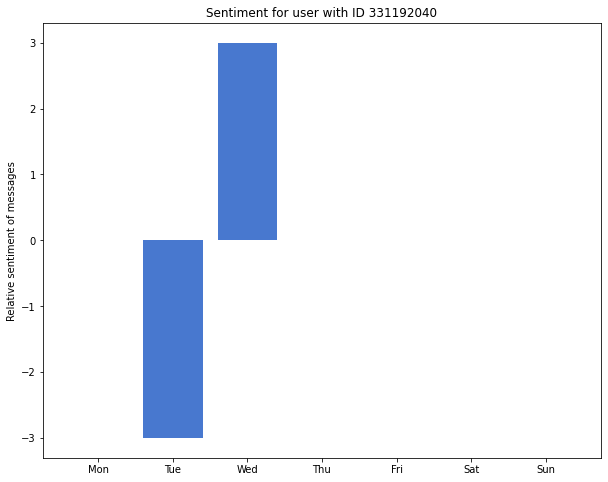

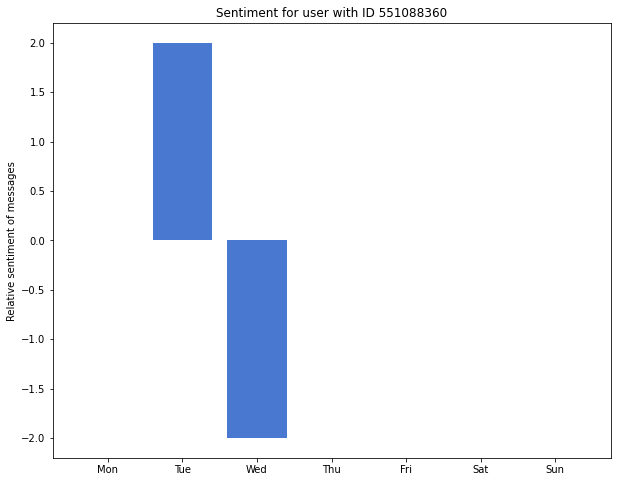

In [4]:
result = sentiment_text_analysis(data)
plot_sentiment_analysis_results(result)

In [ ]:
# TODO: add plot for sentiment by hours for a week. start 00:00 mon - end sun 23:59, it should be curve line
# TODO: plot same graph for all dialogs
# TODO: add a new column to the dialog DF - sentiment - it should be measurment of the sentiment for current message, it should work with ukrainian, english and russian languages
